# Create Raster Intersection Heatmaps

## imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap

import os
from pathlib import Path

### Collect Data Paths

In [2]:
# data dir
data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data', 'output_data')

# output figure dir
fig_dir = os.path.join(os.path.dirname(os.getcwd()), 'figures')

# dac analysis files
cg_dac_path = os.path.join(data_dir, 'clean_grid_dac_analysis.csv')
bau_dac_path = os.path.join(data_dir, 'bau_dac_analysis.csv')
diff_dac_path = os.path.join(data_dir, 'difference_dac_analysis.csv')

# farmland dir
cg_farm_path = os.path.join(data_dir, 'clean_grid_farm_analysis.csv')
bau_farm_path = os.path.join(data_dir, 'bau_farm_analysis.csv')
diff_farm_path = os.path.join(data_dir, 'difference_farm_analysis.csv')

# environmental dir
cg_env_path = os.path.join(data_dir, 'clean_grid_env_analysis.csv')
bau_env_path = os.path.join(data_dir, 'bau_env_analysis.csv')
diff_env_path = os.path.join(data_dir, 'difference_env_analysis.csv')

### Collect Data

In [3]:
# dac analysis files
cg_dac_df = pd.read_csv(cg_dac_path)
bau_dac_df = pd.read_csv(bau_dac_path)
diff_dac_df = pd.read_csv(diff_dac_path)

# farmland dir
cg_farm_df = pd.read_csv(cg_farm_path)
bau_farm_df = pd.read_csv(bau_farm_path)
diff_farm_df = pd.read_csv(diff_farm_path)

# environmental dir
cg_env_df = pd.read_csv(cg_env_path)
bau_env_df = pd.read_csv(bau_env_path)
diff_env_df = pd.read_csv(diff_env_path)

### Settings

In [4]:
# dictionary of DAC layers with their simple names
dac_dict = {'west_usceq_combined_vulnerable_communities.tif': 'DACs',
            'west_usceq_energy_vulnerable_communities.tif': 'Energy DACs',
            'west_usceq_transportation_vulnerable_communities.tif': 'Transportation DACs',
            'west_usceq_housing_vulnerable_communities.tif':'Housing DACs',
            'west_usceq_pollution_vulnerable_communities.tif':'Pollution DACs',
            'west_usceq_health_vulnerable_communities.tif':'Health DACs',
            'west_usceq_climate_vulnerable_communities.tif':'Climate DACs',
            'west_usceq_workforce_vulnerable_communities.tif':'Workforce DACs',
            'west_usceq_water_vulnerable_communities.tif':'Water DACs'}

# dictionary of important farmland layers with their simple names
farm_dict = {'west_usda_combined_important_farmland.tif': 'Important Farmland',
            'west_usda_prime_farmland_classification.tif': 'Prime Farmland',
            'west_usda_farmland_of_state_importance.tif': 'Farmland of State Importance',
            'west_usda_farmland_of_local_importance.tif':'Farmland of Local Importance',
            'west_usda_farmland_of_unique_importance.tif':'Farmland of Unique Importance'}

# dictionary of environmental layers with their simple names
env_dict = {'west_analysis_combined_environment.tif': 'Natural Areas',
           'west_analysis_combined_environment_1buff.tif': 'Within 1 km of Natural Area',
           'west_analysis_combined_environment_5buff.tif': 'Within 5 km of Natural Area',
           'west_analysis_combined_environment_10buff.tif': 'Within 10 km of Natural Area',
           }

### Functions

In [5]:

def calculate_total_intersections_by_layer(analysis_df, layer_dict, level=None):
    
    """This function takes an intersection analysis output dataframe and groups it to the level 
    indicated. A level value of None summarizes intersections across all parameters, level='tech'
    summarizes intersections by technology type. level='state' summarizes intersections by state.
    level='tech_state' summarizes intersections by both technology and state.
    
    """

    if level is None:
        # group by layer
        df = analysis_df.groupby(['layer'], as_index=False, observed=False).sum()
        output_layer_list = ['layer_name', 'total_plants', 'intersection', 'fraction']
        index_values = []

    elif level == 'tech':
        # group by layer & tech
        df = analysis_df.groupby(['layer', 'tech_name'], as_index=False, observed=False).sum()
        output_layer_list = ['layer_name', 'tech_name', 'total_plants', 'intersection', 'fraction']
        index_values = ['tech_name']

    elif level == 'state':
        # group by layer & state
        df = analysis_df.groupby(['layer', 'state'], as_index=False, observed=False).sum()
        output_layer_list = ['layer_name', 'state', 'total_plants', 'intersection', 'fraction']   
        index_values = ['state']

    elif level == 'state_tech':
        # group by layer & state & tech
        df = analysis_df.groupby(['layer', 'state', 'tech_name'], as_index=False, observed=False).sum()
        output_layer_list = ['layer_name', 'state', 'tech_name', 'total_plants', 'intersection', 'fraction']   
        index_values = ['tech_name', 'state']

    if 'total_plants_x' in df.columns:
        output_layer_list.remove('total_plants')
        output_layer_list.remove('fraction')
        
    else:   
        # recalculate intersection fraction
        df['fraction'] = round(df['intersection'] / df['total_plants'], 2)
        
    # simplify naming
    df['layer_name'] = df['layer'].map(layer_dict)

    df[output_layer_list]

    df = pd.pivot_table(df, values='intersection', index=index_values, columns=['layer_name'], aggfunc='sum')

    # sort columns by preferred order
    sort_list = list(layer_dict.values())

    df = df[sort_list]
    
    return df



def plot_heatmap(plot_df, output_file_name, title='', figsize= (12, 12)): 
    """
    Creates a heatmap of supplied dataframe.
    """
    
    color_cmap = ["gold", "seagreen"]
    cmap1 = LinearSegmentedColormap.from_list('', color_cmap)
    fig, ax = plt.subplots(figsize=figsize)
        
    data = plot_df.to_numpy()
    plt.pcolor(plot_df, cmap=cmap1, edgecolors='black', linewidths=1)
    plt.yticks(np.arange(0.5, len(plot_df.index), 1), plot_df.index)
    plt.xticks(np.arange(0.5, len(plot_df.columns), 1), plot_df.columns)
    for i in range(len(plot_df)):
        for j in range(len(list(plot_df.columns))):
            plt.annotate(str(data[i][j]), xy=(j+0.5, i+0.5),
                         ha='center', va='center', color='black')
    cbar = plt.colorbar(shrink= .5, label = '$km^2$')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')

    # save figure to folder
    plt.savefig(os.path.join(fig_dir, output_file_name))

    return plt.show()   


________________

# Heatmaps

## Disadvantaged Communities

<b> Scientific Question Addressed </b>: Under decarbonization and business-as-usual scenarios, how much land required for new power plant infrastructure intersects with federally-identified disadvantaged communities?

In [6]:
analysis_type = 'DAC Layers'
layer_dict = dac_dict

#### Clean Grid by 2035 - New Power Plant Sitings

In [7]:
scenario = 'Clean Grid by 2035'

analysis_df = cg_dac_df.copy()

##### Calculate Total Intersections by Layer


Intersections with DAC Layers, Clean Grid by 2035:



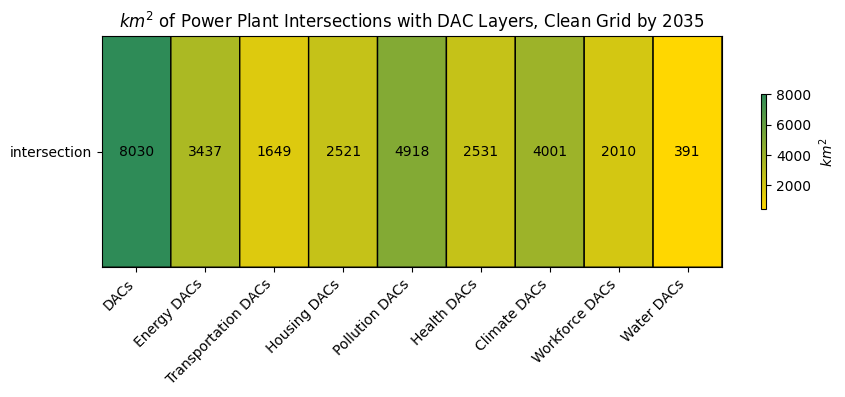

In [8]:
intersection_label = f'Intersections with {analysis_type}, {scenario}'

print(f'\n{intersection_label}:\n')
total_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level=None)

plot_heatmap(plot_df=total_intersections, title=f'$km^2$ of Power Plant {intersection_label}', 
             figsize=(10, 3), output_file_name='layer_heatmaps/heatmap_clean_grid_total_dac.png')

##### Calculate Total Intersections by Technology


Intersections by technology type with DAC Layers, Clean Grid by 2035:



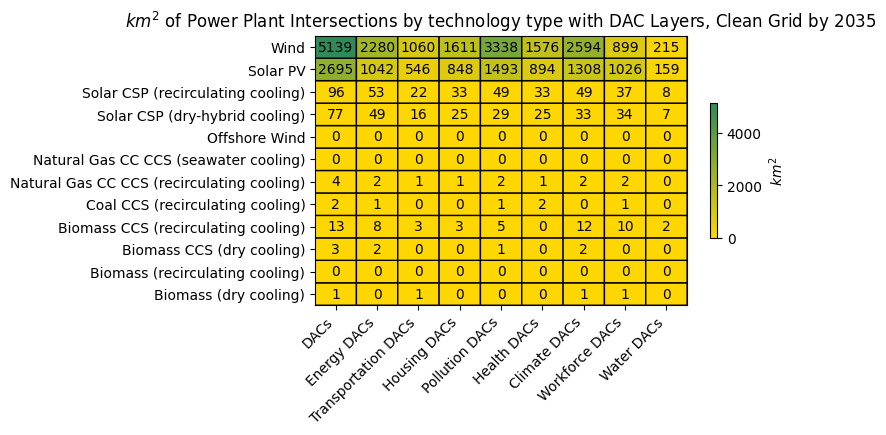

In [9]:
intersection_label = f'Intersections by technology type with {analysis_type}, {scenario}'

print(f'\n{intersection_label}:\n')
tech_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='tech')

plot_heatmap(plot_df=tech_intersections, title=f'$km^2$ of Power Plant {intersection_label}',
             output_file_name='layer_heatmaps/heatmap_clean_grid_tech_dac.png', figsize=(6, 3.5))

##### Calculate Total Intersections by State


Intersections by State with DAC Layers, Clean Grid by 2035:



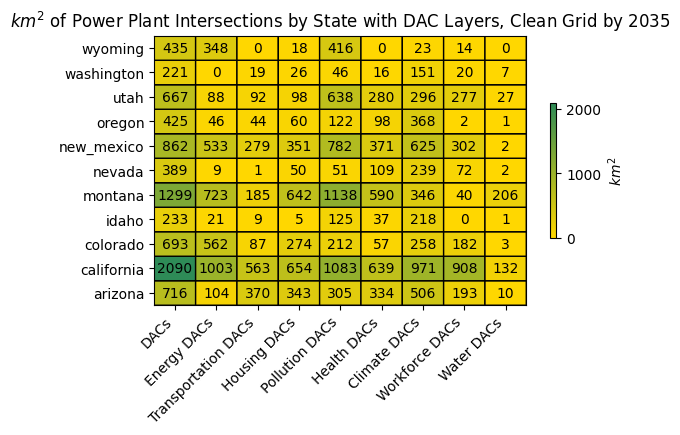

In [10]:
intersection_label = f'Intersections by State with {analysis_type}, {scenario}'

print(f'\n{intersection_label}:\n')
state_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state')

plot_heatmap(plot_df=state_intersections, title=f'$km^2$ of Power Plant {intersection_label}',
             output_file_name='layer_heatmaps/heatmap_clean_grid_state_dac.png', figsize=(6, 3.5))

##### Calculate Total Intersections by State & Technology


Intersections by state and technology with DAC Layers, Clean Grid by 2035:



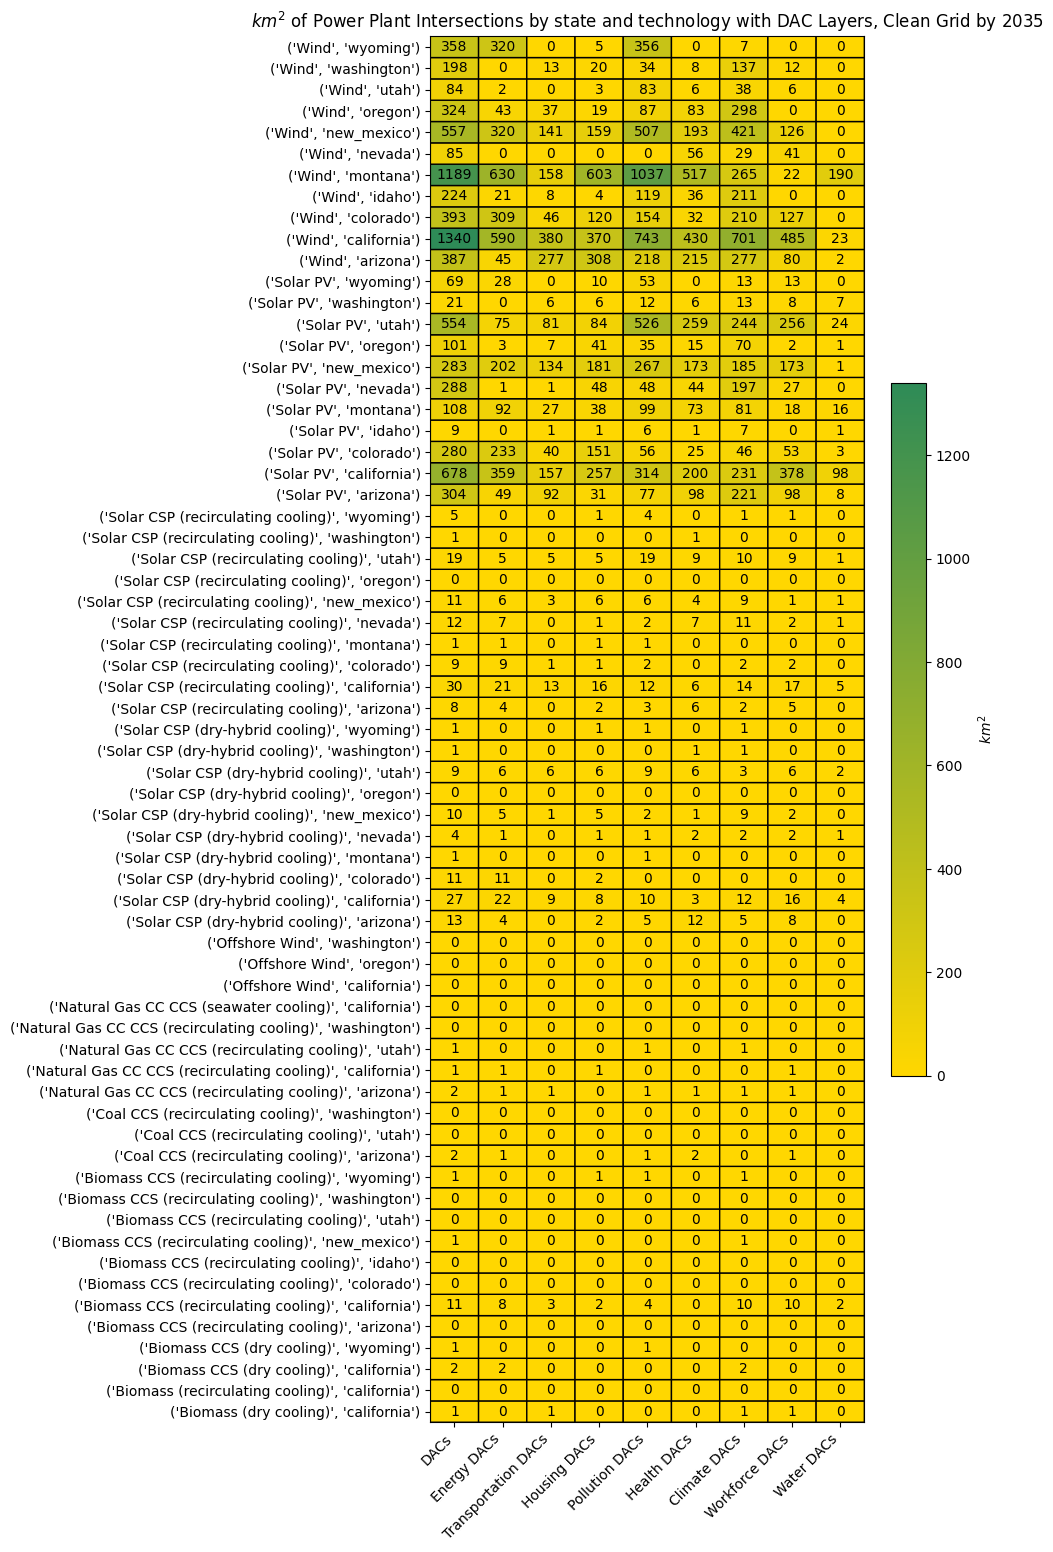

In [11]:
intersection_label = f'Intersections by state and technology with {analysis_type}, {scenario}'

print(f'\n{intersection_label}:\n')
state_tech_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state_tech')

plot_heatmap(plot_df=state_tech_intersections, title=f'$km^2$ of Power Plant {intersection_label}', figsize=(7, 18),
             output_file_name='layer_heatmaps/heatmap_clean_grid_tech_state_dac.png')

#### <b> Business-as-usual by 2035 - New Power Plant Sitings </b>

In [12]:
scenario = 'Business-as-usual by 2035'

analysis_df = bau_dac_df.copy()

##### Calculate Total Intersections by Layer


Intersections with DAC Layers, Business-as-usual by 2035:



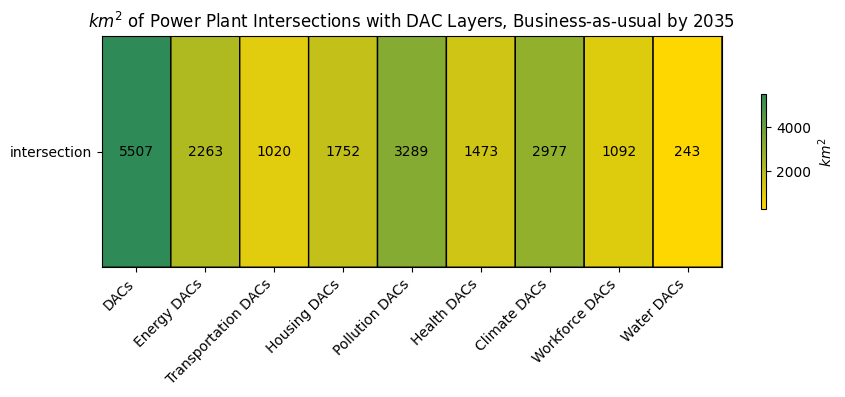

In [13]:
intersection_label = f'Intersections with {analysis_type}, {scenario}'

print(f'\n{intersection_label}:\n')
total_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level=None)

plot_heatmap(plot_df=total_intersections, title=f'$km^2$ of Power Plant {intersection_label}', 
             figsize=(10, 3), output_file_name='layer_heatmaps/heatmap_bau_total_dac.png')

##### Calculate Total Intersections by Technology


Intersections by technology type with DAC Layers, Business-as-usual by 2035:



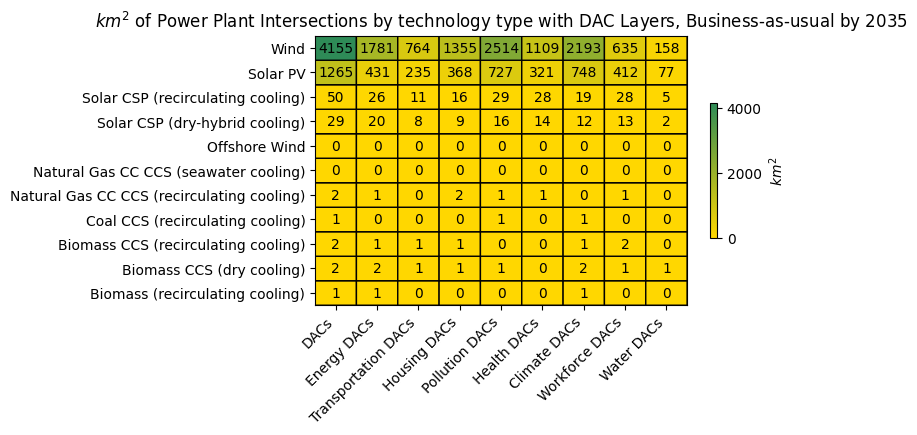

In [14]:
intersection_label = f'Intersections by technology type with {analysis_type}, {scenario}'

print(f'\n{intersection_label}:\n')
tech_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='tech')

plot_heatmap(plot_df=tech_intersections, title=f'$km^2$ of Power Plant {intersection_label}',figsize=(6, 3.5),
             output_file_name='layer_heatmaps/heatmap_bau_tech_dac.png')

##### Calculate Total Intersections by State


Intersections by state with DAC Layers, Business-as-usual by 2035:



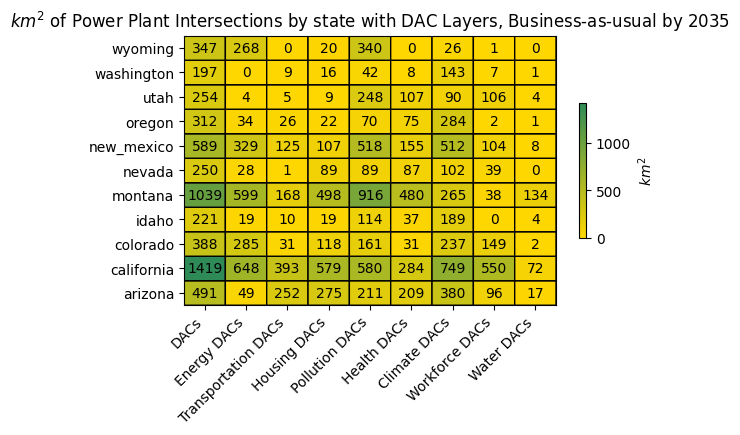

In [15]:
intersection_label = f'Intersections by state with {analysis_type}, {scenario}'

print(f'\n{intersection_label}:\n')
state_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state')

plot_heatmap(plot_df=state_intersections, title=f'$km^2$ of Power Plant {intersection_label}',figsize=(6, 3.5),
             output_file_name='layer_heatmaps/heatmap_bau_state_dac.png')

##### Calculate Total Intersections by State & Technology


Intersections by state and technology with DAC Layers, Business-as-usual by 2035:



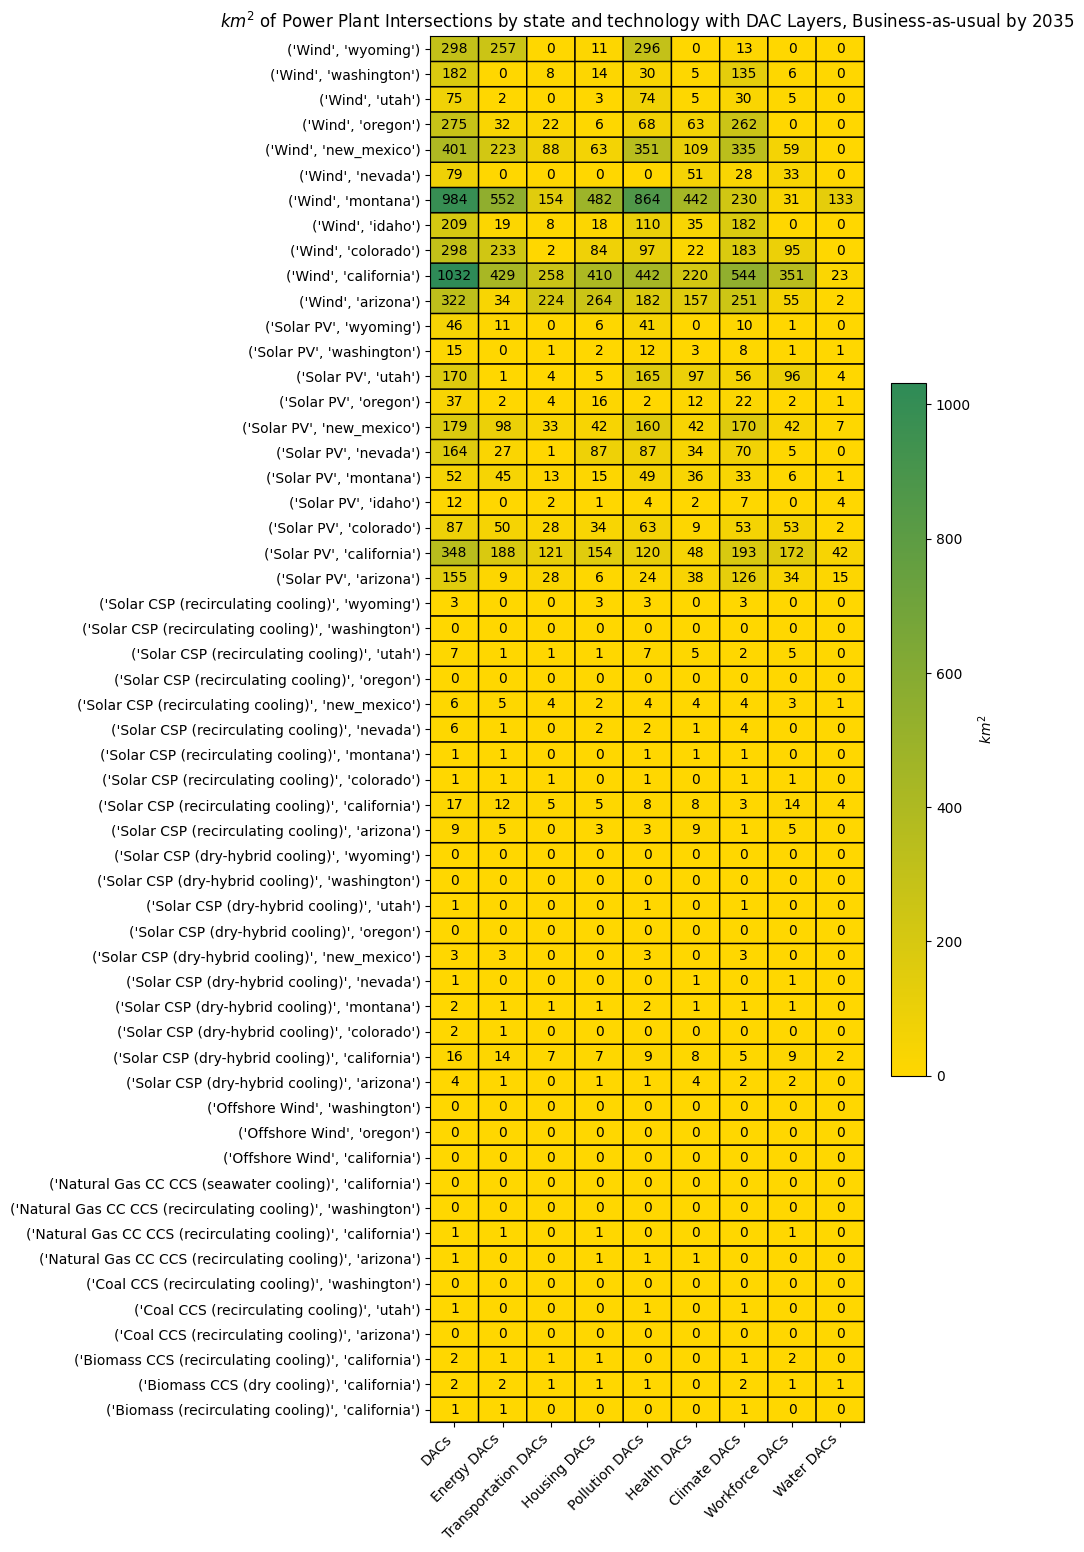

In [16]:
intersection_label = f'Intersections by state and technology with {analysis_type}, {scenario}'

print(f'\n{intersection_label}:\n')
state_tech_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state_tech')

plot_heatmap(plot_df=state_tech_intersections, title=f'$km^2$ of Power Plant {intersection_label}', figsize=(7, 18),
             output_file_name='layer_heatmaps/heatmap_bau_tech_state_dac.png')

## Important Farmland

<b> Scientific Question Addressed </b>: Under decarbonization and business-as-usual scenarios, how much land required for new power plant infrastructure intersects with important farmland?

In [17]:
analysis_type = 'Important Farmland Layers'
layer_dict = farm_dict

#### **Clean Grid by 2035 - New Power Plant Sitings**

In [18]:
scenario = 'Clean Grid by 2035'
analysis_df = cg_farm_df.copy()

##### Calculate Total Intersections by Layer


Intersections with Important Farmland Layers, Clean Grid by 2035:



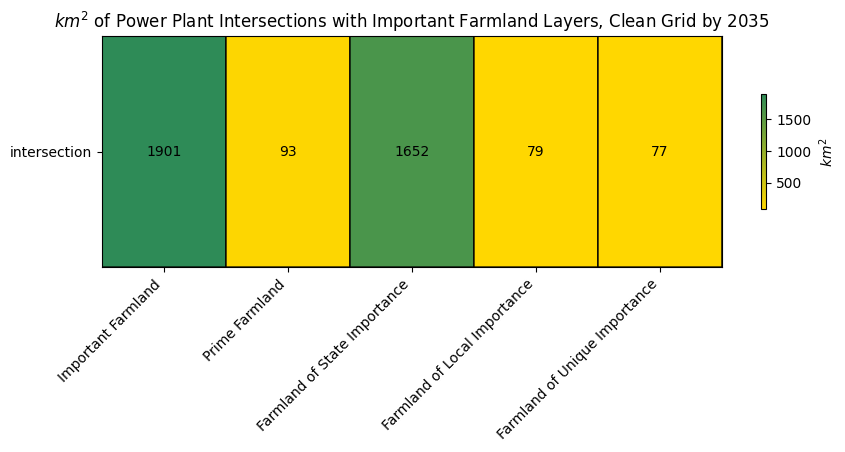

In [19]:
intersection_label = f'Intersections with {analysis_type}, {scenario}'

print(f'\n{intersection_label}:\n')
total_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level=None)

plot_heatmap(plot_df=total_intersections, title=f'$km^2$ of Power Plant {intersection_label}', 
             figsize=(10, 3), output_file_name='layer_heatmaps/heatmap_clean_grid_total_important_farmland.png')

##### Calculate Total Intersections by Technology


Intersections by technology type with Important Farmland Layers, Clean Grid by 2035:



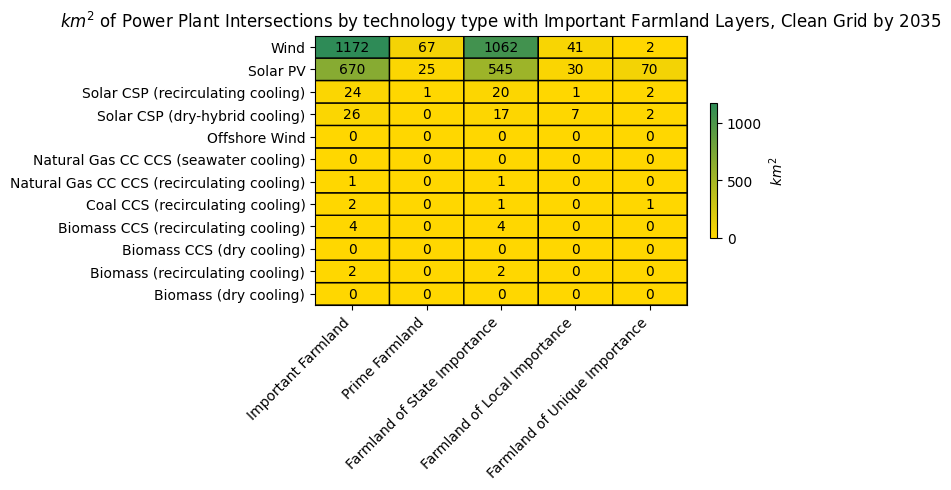

In [20]:
intersection_label = f'Intersections by technology type with {analysis_type}, {scenario}'

print(f'\n{intersection_label}:\n')
tech_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='tech')

plot_heatmap(plot_df=tech_intersections, title=f'$km^2$ of Power Plant {intersection_label}',figsize=(6, 3.5),
             output_file_name='layer_heatmaps/heatmap_clean_grid_tech_important_farmland.png')

##### Calculate Total Intersections by State


Intersections by state with Important Farmland Layers, Clean Grid by 2035:



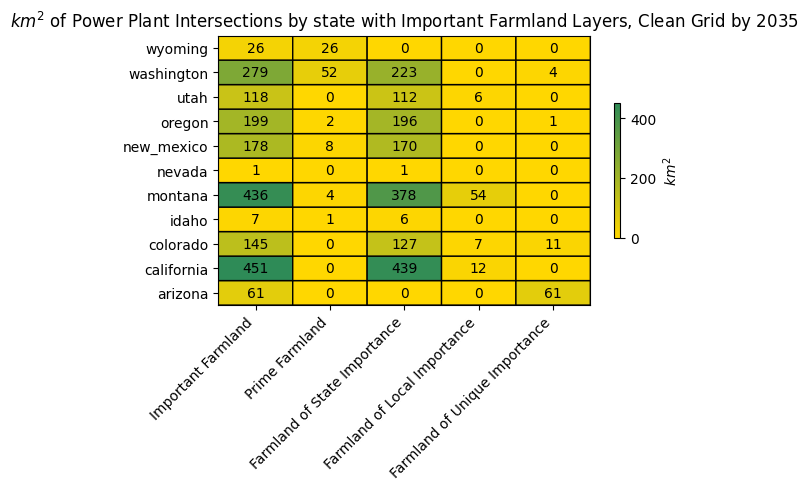

In [21]:
intersection_label = f'Intersections by state with {analysis_type}, {scenario}'

print(f'\n{intersection_label}:\n')
state_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state')

plot_heatmap(plot_df=state_intersections, title=f'$km^2$ of Power Plant {intersection_label}',figsize=(6, 3.5),
             output_file_name='layer_heatmaps/heatmap_clean_grid_state_important_farmland.png')

##### Calculate Total Intersections by State & Technology


Intersections by state and technology with Important Farmland Layers, Clean Grid by 2035:



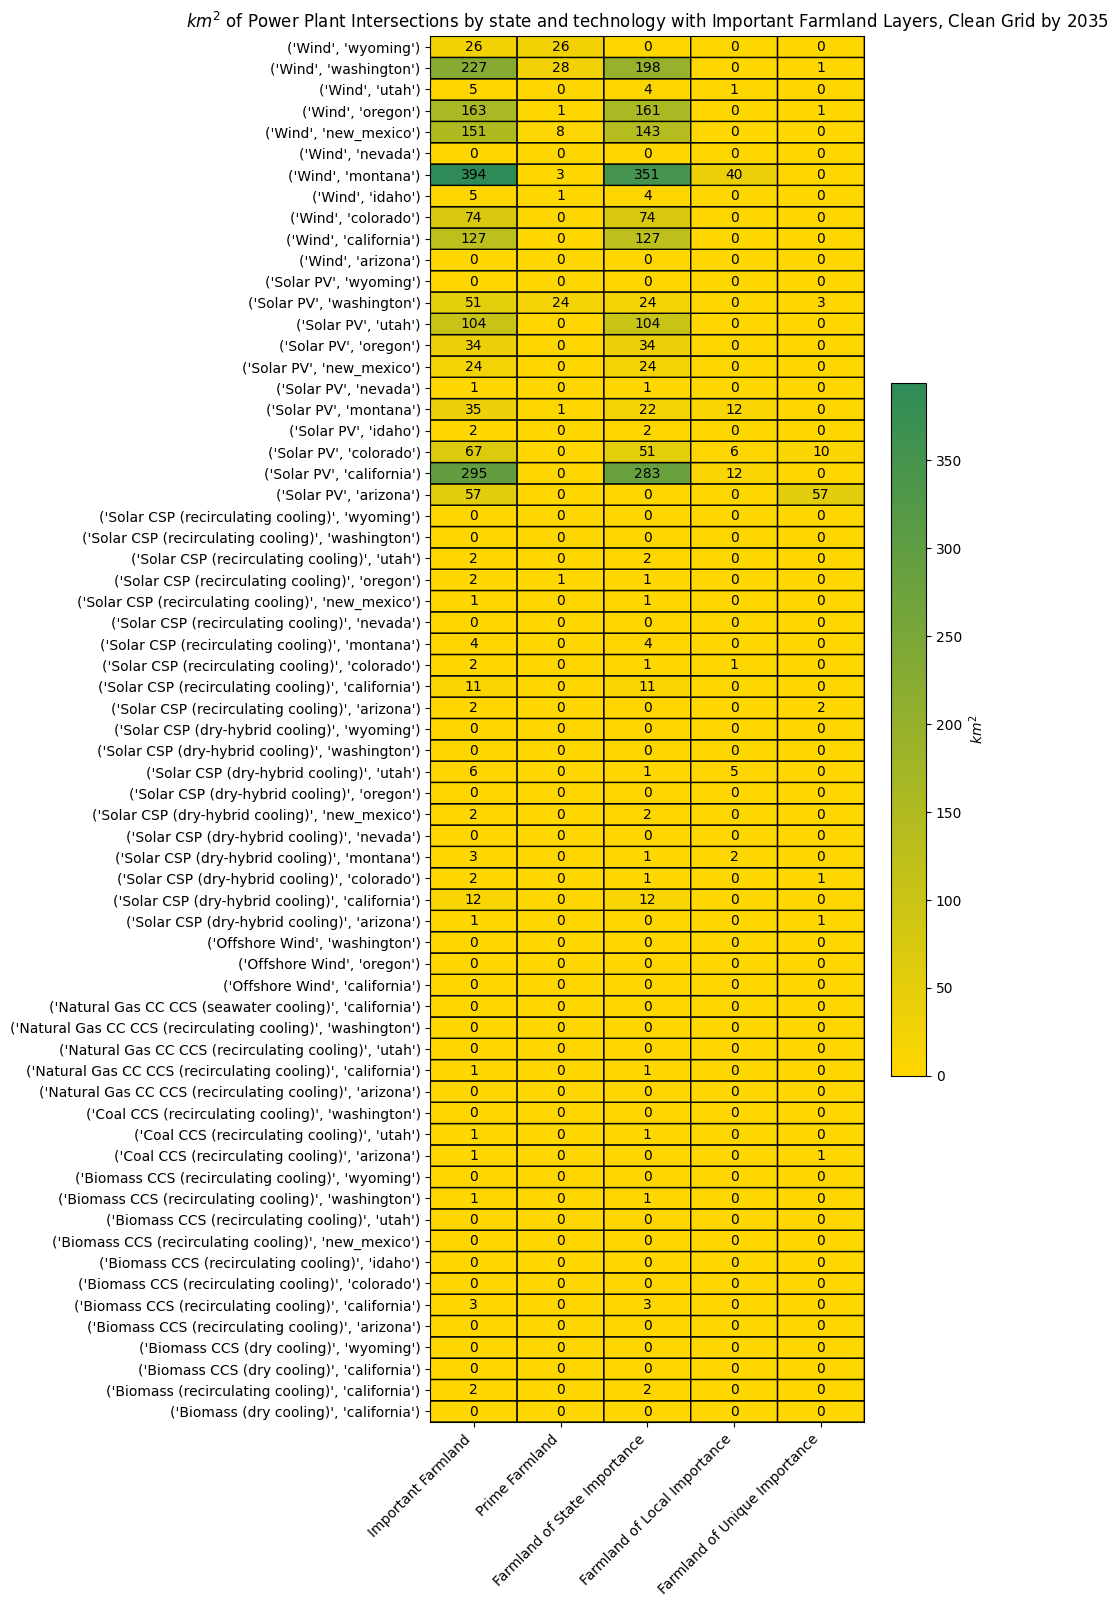

In [22]:
intersection_label = f'Intersections by state and technology with {analysis_type}, {scenario}'

print(f'\n{intersection_label}:\n')
state_tech_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state_tech')

plot_heatmap(plot_df=state_tech_intersections, title=f'$km^2$ of Power Plant {intersection_label}', figsize=(7, 18),
             output_file_name='layer_heatmaps/heatmap_clean_grid_tech_state_important_farmland.png')

#### **Business-as-usual by 2035 - New Power Plant Sitings**

In [23]:
scenario = 'Business-as-usual by 2035'
analysis_df = bau_farm_df.copy()

##### Calculate Total Intersections by Layer


Intersections with Important Farmland Layers, Business-as-usual by 2035:



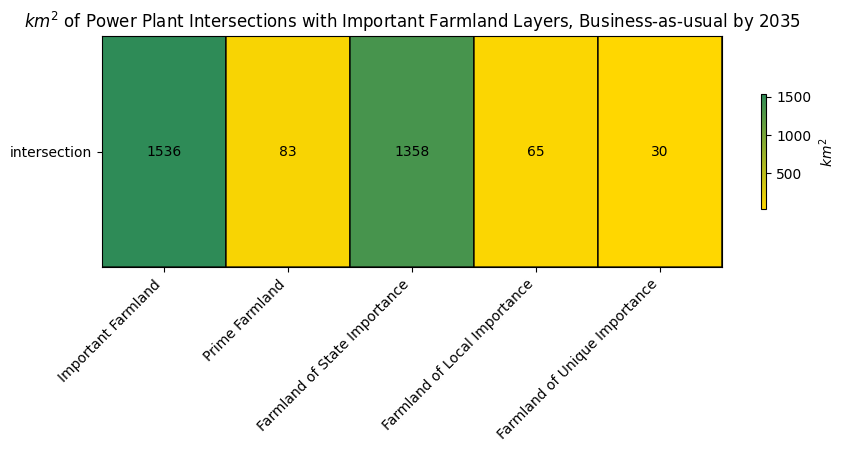

In [24]:
intersection_label = f'Intersections with {analysis_type}, {scenario}'

print(f'\n{intersection_label}:\n')
total_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level=None)

plot_heatmap(plot_df=total_intersections, title=f'$km^2$ of Power Plant {intersection_label}', 
             figsize=(10, 3), output_file_name='layer_heatmaps/heatmap_bau_total_important_farmland.png')

##### Calculate Total Intersections by Technology


Intersections by technology type with Important Farmland Layers, Business-as-usual by 2035:



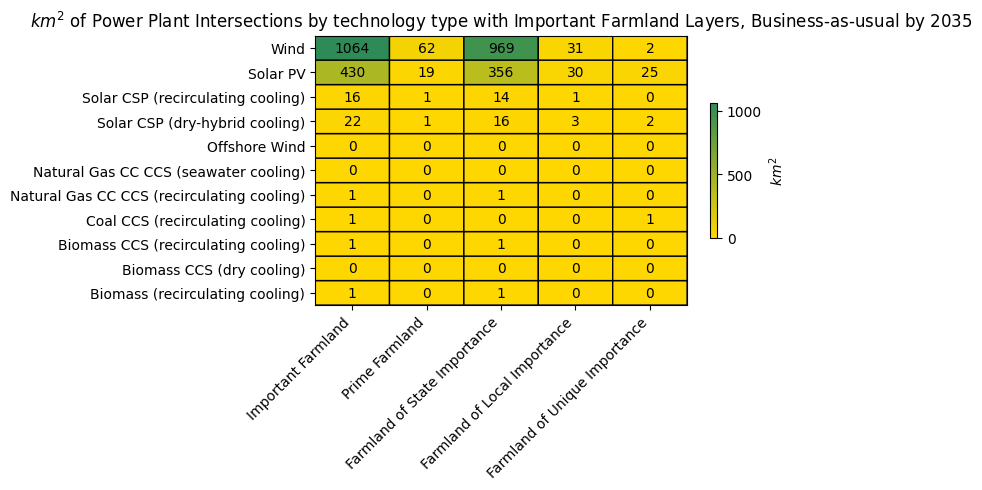

In [25]:
intersection_label = f'Intersections by technology type with {analysis_type}, {scenario}'

print(f'\n{intersection_label}:\n')
tech_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='tech')

plot_heatmap(plot_df=tech_intersections, title=f'$km^2$ of Power Plant {intersection_label}',figsize=(6, 3.5),
             output_file_name='layer_heatmaps/heatmap_bau_tech_important_farmland.png')

##### Calculate Total Intersections by State


Intersections by state with Important Farmland Layers, Business-as-usual by 2035:



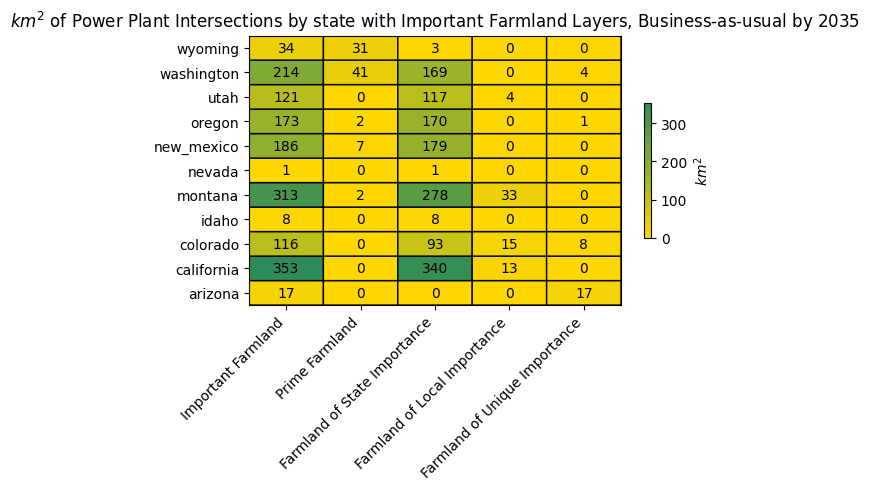

In [26]:
intersection_label = f'Intersections by state with {analysis_type}, {scenario}'

print(f'\n{intersection_label}:\n')
state_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state')

plot_heatmap(plot_df=state_intersections, title=f'$km^2$ of Power Plant {intersection_label}',figsize=(6, 3.5),
             output_file_name='layer_heatmaps/heatmap_bau_state_important_farmland.png')

##### Calculate Total Intersections by State & Technology


Intersections by state and technology with Important Farmland Layers, Business-as-usual by 2035:



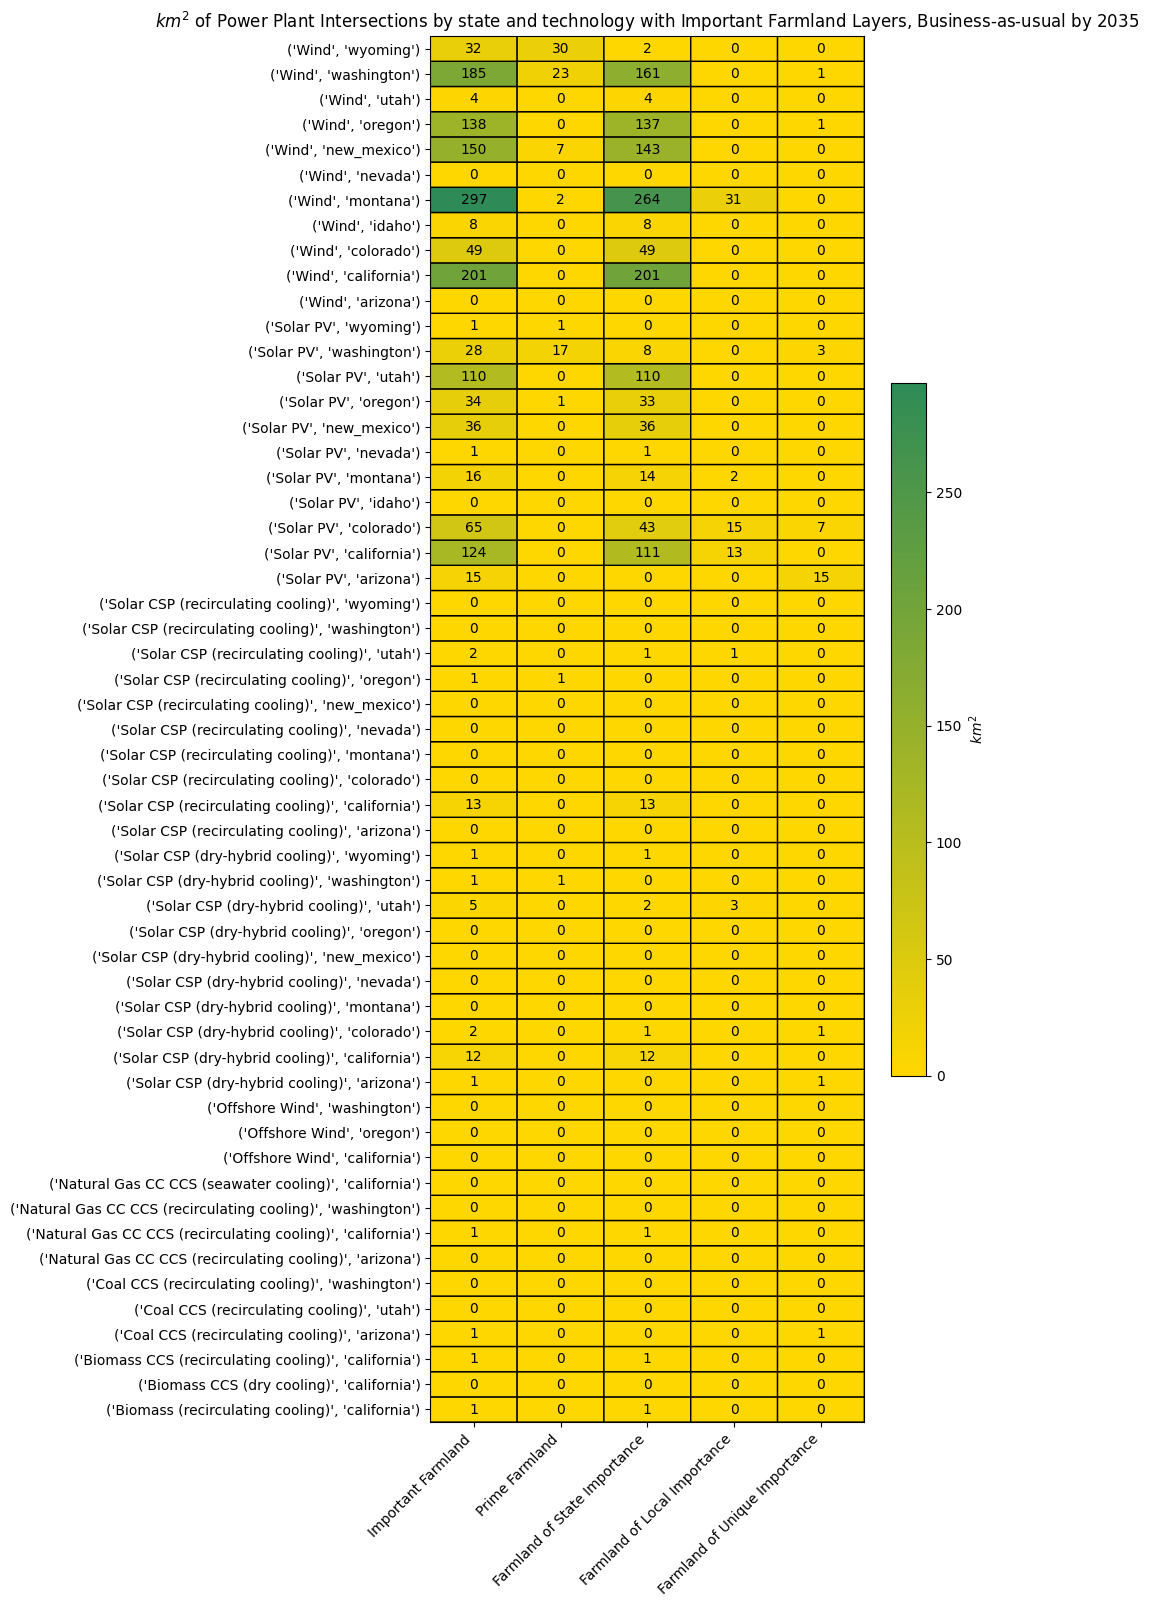

In [27]:
intersection_label = f'Intersections by state and technology with {analysis_type}, {scenario}'

print(f'\n{intersection_label}:\n')
state_tech_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state_tech')

plot_heatmap(plot_df=state_tech_intersections, title=f'$km^2$ of Power Plant {intersection_label}', figsize=(7, 18),
             output_file_name='layer_heatmaps/heatmap_bau_tech_state_important_farmland.png')

## Natural Area Proximity

<b> Scientific Question Addressed </b>: Under decarbonization and business-as-usual scenarios, how much land required for new power plant infrastructure intersects with areas in close proximity to natural areas?

In [28]:
analysis_type = 'Natural Area Layers'
layer_dict = env_dict

#### **Clean Grid by 2035 - New Power Plant Sitings**

In [29]:
scenario = 'Clean Grid by 2035'
analysis_df = cg_env_df.copy()

##### Calculate Total Intersections by Layer


Intersections with Natural Area Layers, Clean Grid by 2035:



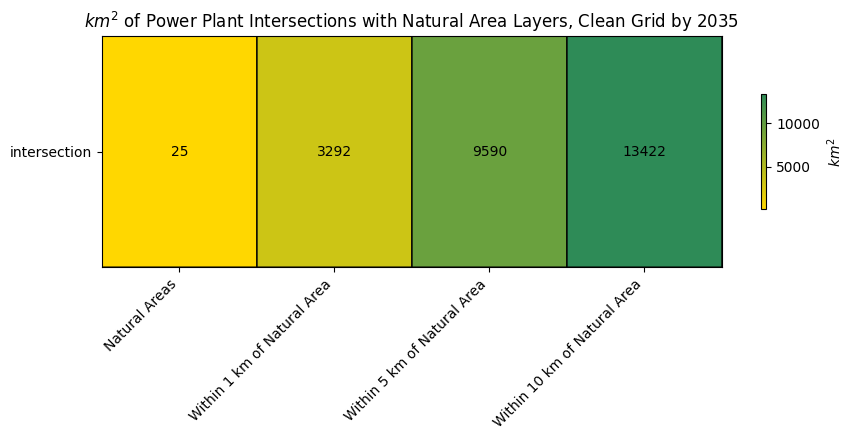

In [30]:
intersection_label = f'Intersections with {analysis_type}, {scenario}'

print(f'\n{intersection_label}:\n')
total_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level=None)

plot_heatmap(plot_df=total_intersections, title=f'$km^2$ of Power Plant {intersection_label}', 
             figsize=(10, 3), output_file_name='layer_heatmaps/heatmap_clean_grid_total_env_proximity.png')

##### Calculate Total Intersections by Technology


Intersections by technology type with Natural Area Layers, Clean Grid by 2035:



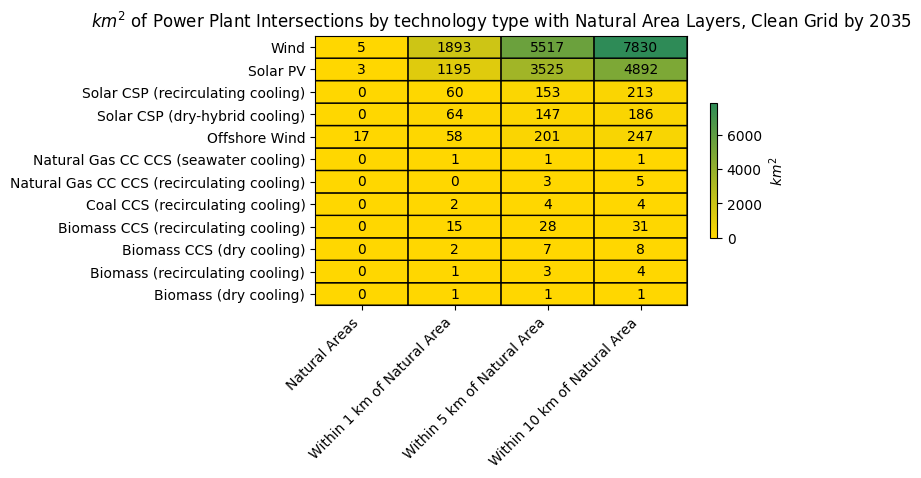

In [31]:
intersection_label = f'Intersections by technology type with {analysis_type}, {scenario}'

print(f'\n{intersection_label}:\n')
tech_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='tech')

plot_heatmap(plot_df=tech_intersections, title=f'$km^2$ of Power Plant {intersection_label}',figsize=(6, 3.5),
             output_file_name='layer_heatmaps/heatmap_clean_grid_tech_env_proximity.png')

##### Calculate Total Intersections by State


Intersections by state with Natural Area Layers, Clean Grid by 2035:



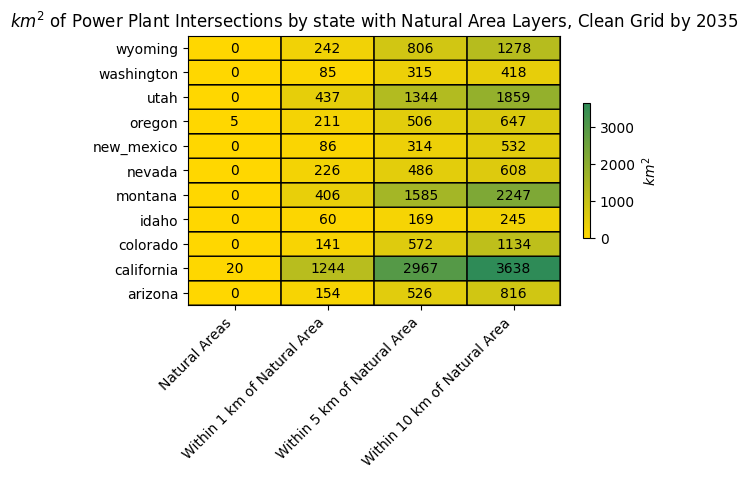

In [32]:
intersection_label = f'Intersections by state with {analysis_type}, {scenario}'

print(f'\n{intersection_label}:\n')
state_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state')

plot_heatmap(plot_df=state_intersections, title=f'$km^2$ of Power Plant {intersection_label}',figsize=(6, 3.5),
             output_file_name='layer_heatmaps/heatmap_clean_grid_state_env_proximity.png')

##### Calculate Total Intersections by State & Technology


Intersections by state and technology with Natural Area Layers, Clean Grid by 2035:



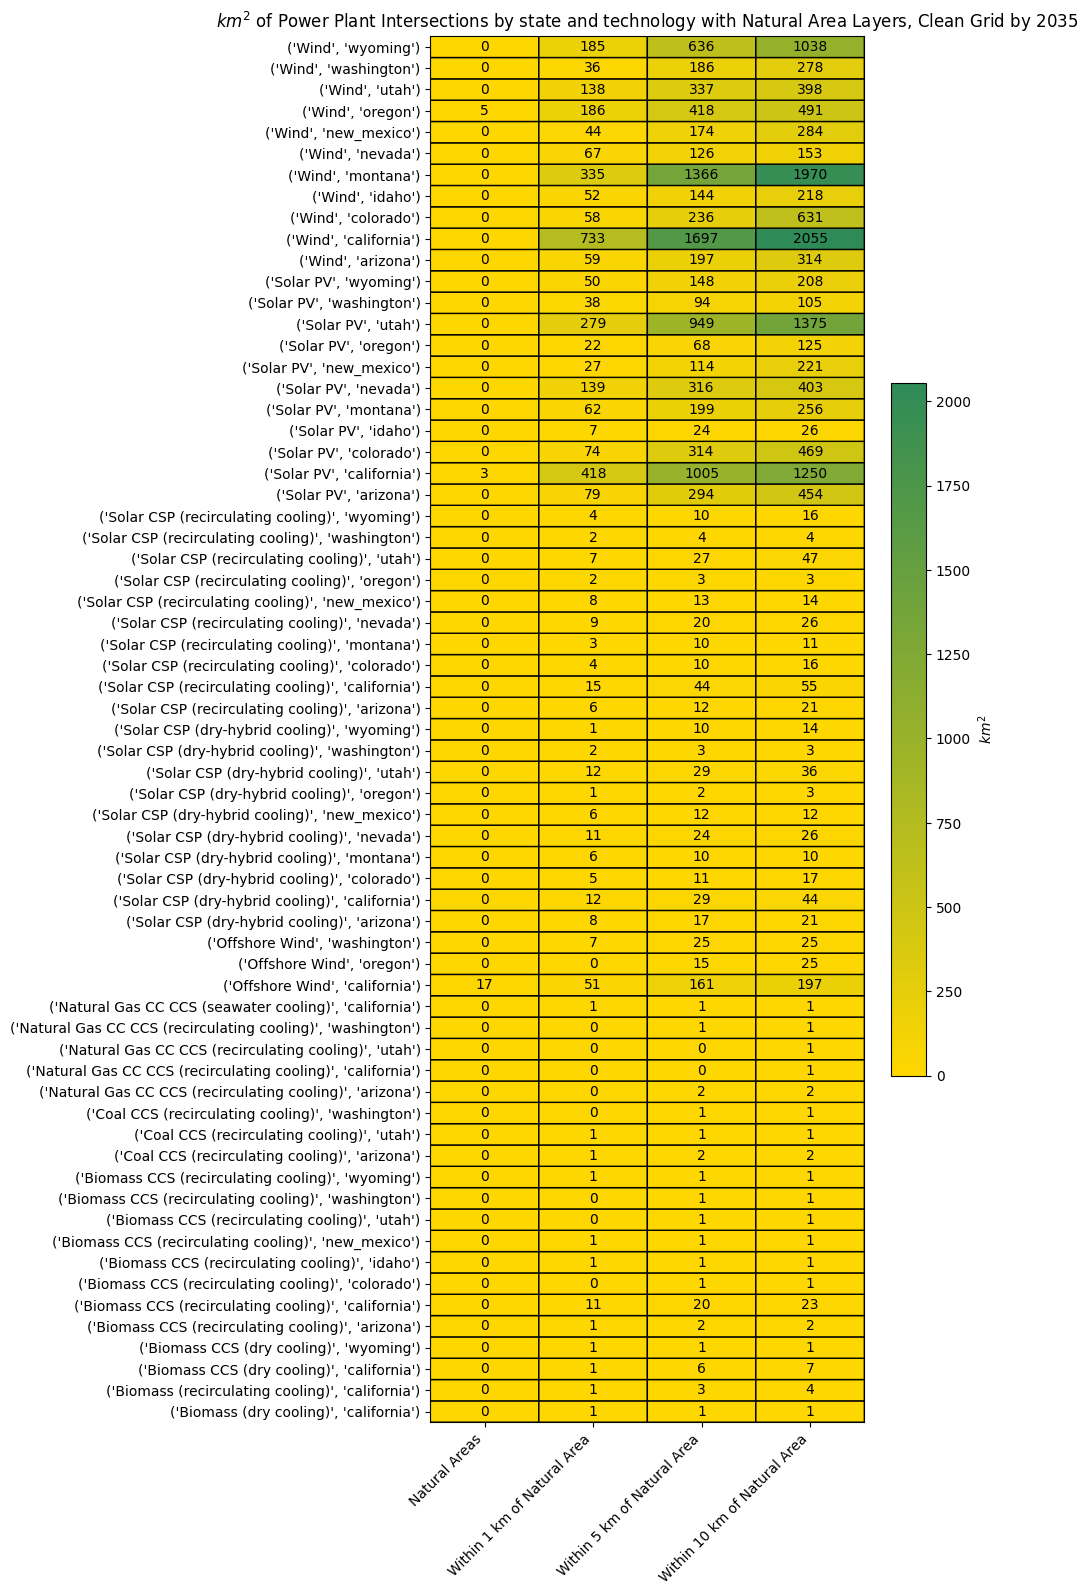

In [33]:
intersection_label = f'Intersections by state and technology with {analysis_type}, {scenario}'

print(f'\n{intersection_label}:\n')
state_tech_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state_tech')

plot_heatmap(plot_df=state_tech_intersections, title=f'$km^2$ of Power Plant {intersection_label}', figsize=(7, 18),
             output_file_name='layer_heatmaps/heatmap_clean_grid_tech_state_env_proximity.png')

#### **Business-as-usual by 2035 - New Power Plant Sitings**

In [34]:
scenario = 'Business-as-usual by 2035'
analysis_df = bau_env_df.copy()

##### Calculate Total Intersections by Layer


Intersections with Natural Area Layers, Business-as-usual by 2035:



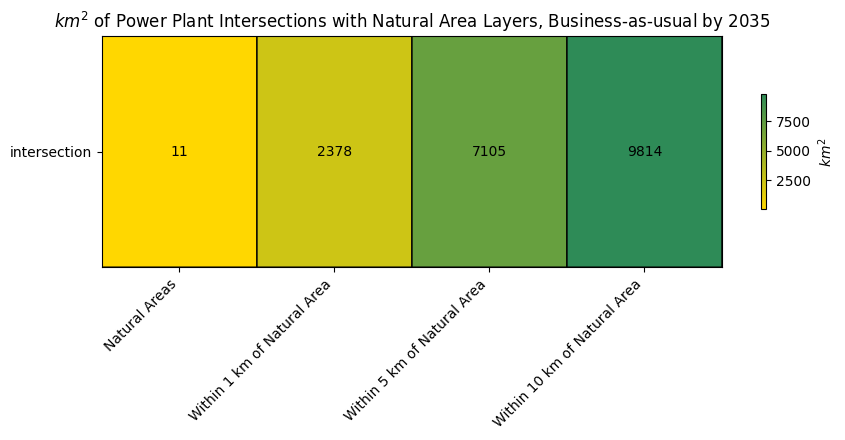

In [35]:
intersection_label = f'Intersections with {analysis_type}, {scenario}'

print(f'\n{intersection_label}:\n')
total_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level=None)

plot_heatmap(plot_df=total_intersections, title=f'$km^2$ of Power Plant {intersection_label}', 
             figsize=(10, 3), output_file_name='layer_heatmaps/heatmap_bau_total_env_proximity.png')

##### Calculate Total Intersections by Technology


Intersections by technology type with Natural Area Layers, Business-as-usual by 2035:



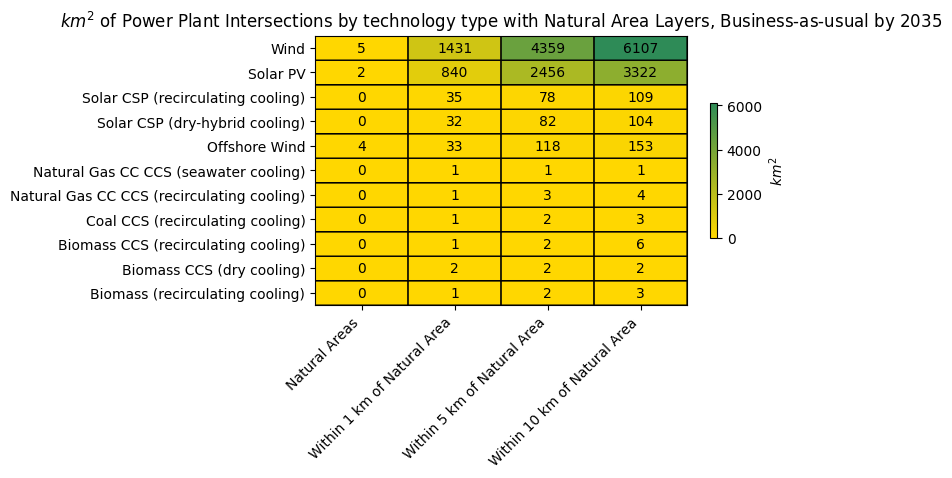

In [36]:
intersection_label = f'Intersections by technology type with {analysis_type}, {scenario}'

print(f'\n{intersection_label}:\n')
tech_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='tech')

plot_heatmap(plot_df=tech_intersections, title=f'$km^2$ of Power Plant {intersection_label}',figsize=(6, 3.5),
             output_file_name='layer_heatmaps/heatmap_bau_tech_env_proximity.png')

##### Calculate Total Intersections by State


Intersections by state with Natural Area Layers, Business-as-usual by 2035:



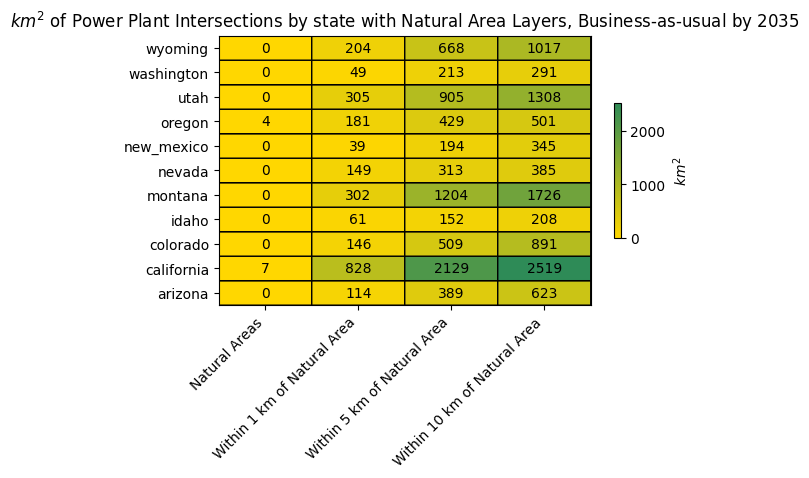

In [37]:
intersection_label = f'Intersections by state with {analysis_type}, {scenario}'

print(f'\n{intersection_label}:\n')
state_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state')

plot_heatmap(plot_df=state_intersections, title=f'$km^2$ of Power Plant {intersection_label}',figsize=(6, 3.5),
             output_file_name='layer_heatmaps/heatmap_bau_state_env_proximity.png')

##### Calculate Total Intersections by State & Technology


Intersections by state and technology with Natural Area Layers, Business-as-usual by 2035:



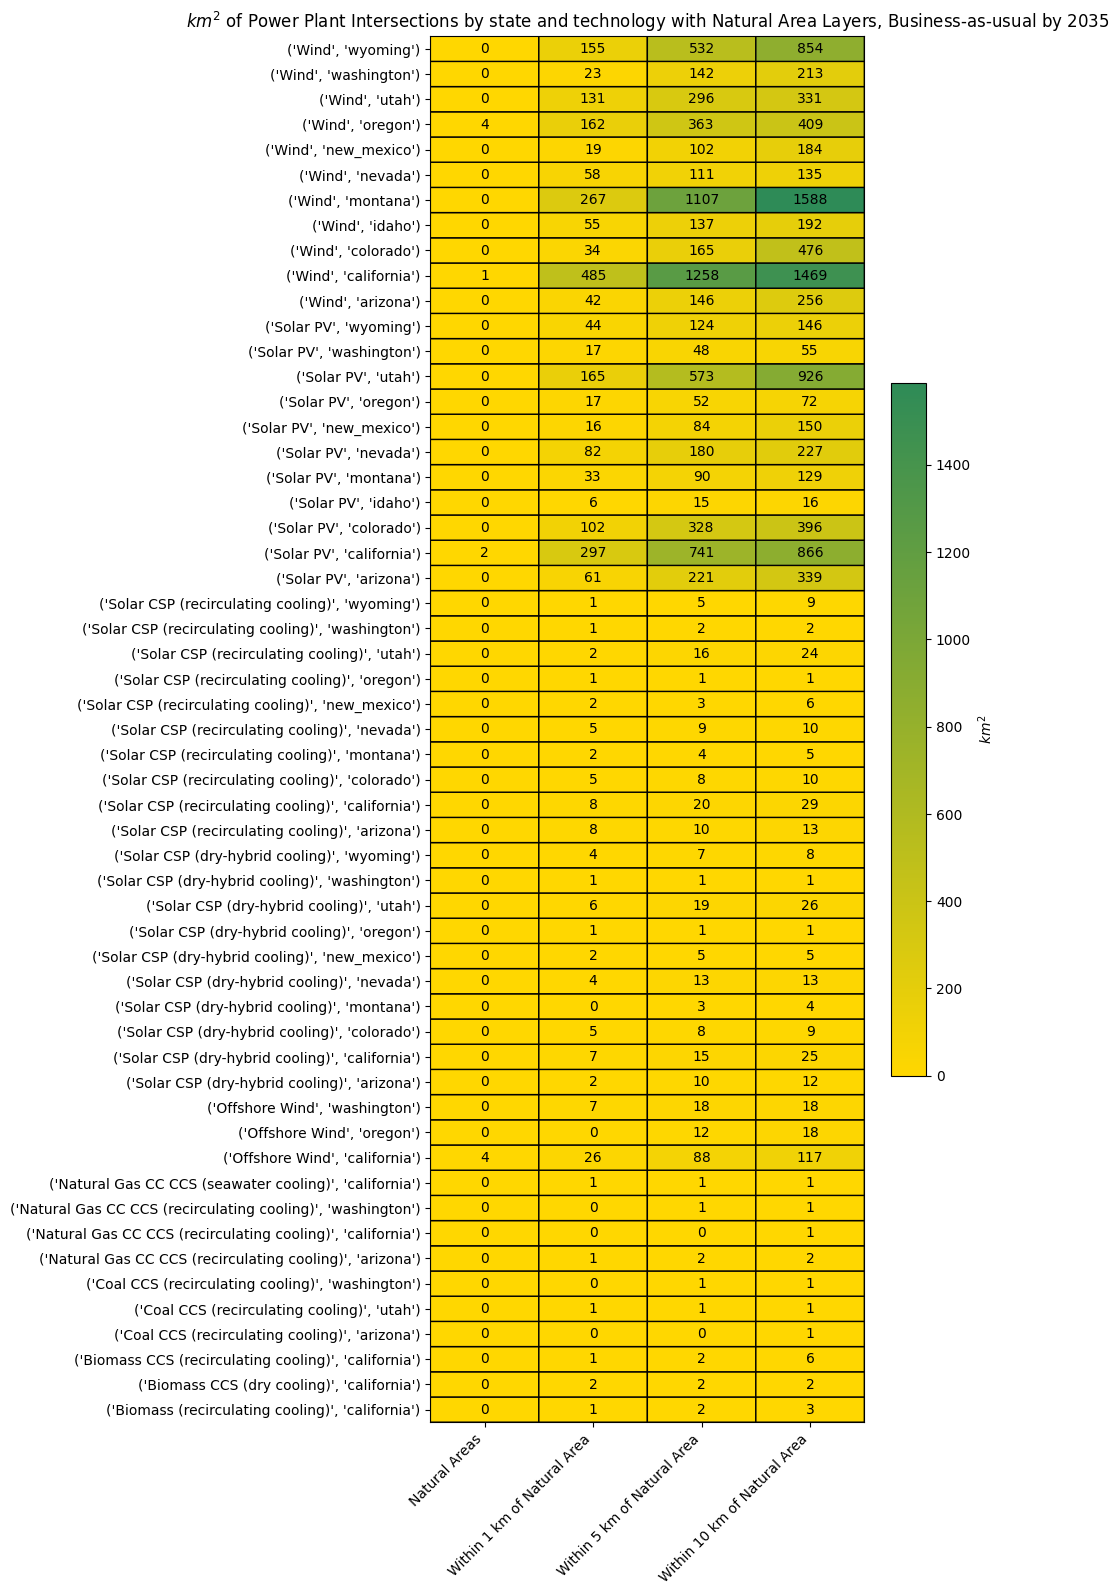

In [38]:
intersection_label = f'Intersections by state and technology with {analysis_type}, {scenario}'

print(f'\n{intersection_label}:\n')
state_tech_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state_tech')

plot_heatmap(plot_df=state_tech_intersections, title=f'$km^2$ of Power Plant {intersection_label}', figsize=(7, 18),
             output_file_name='layer_heatmaps/heatmap_bau_tech_state_env_proximity.png')

_____________

# Difference Analysis
This section calculates the additional land intersections between the Clean Grid and Business-as-usual scenario.

<b>Scientific Question:</b> How much <i>additional</i> land in areas of interest will achieving a decarbonized grid take? 

In [39]:
analysis_type = 'DAC Layers'
layer_dict = dac_dict

## Disadvantaged Communities

In [40]:
analysis_df = diff_dac_df.copy()

##### Calculate Total Intersections by Layer

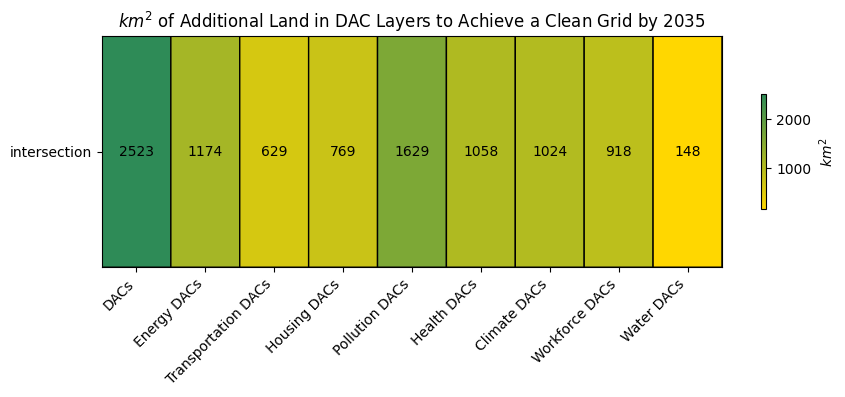

In [41]:
total_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level=None)

plot_heatmap(plot_df=total_intersections, title=f'$km^2$ of Additional Land in {analysis_type} to Achieve a Clean Grid by 2035', 
             figsize=(10, 3), output_file_name='layer_heatmaps/heatmap_diff_total_farmland.png')

##### Calculate Total Intersections by Technology

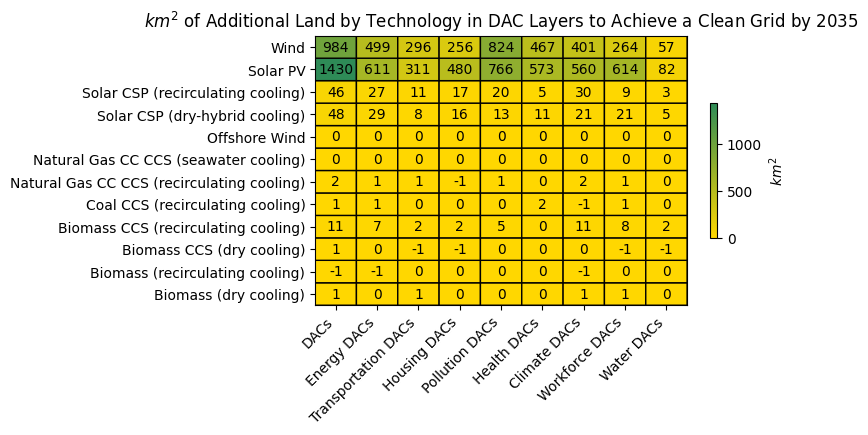

In [42]:
tech_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='tech')

plot_heatmap(plot_df=tech_intersections, 
             title=f'$km^2$ of Additional Land by Technology in {analysis_type} to Achieve a Clean Grid by 2035',figsize=(6, 3.5),
             output_file_name='layer_heatmaps/heatmap_diff_tech_dac.png')

##### Calculate Total Intersections by State

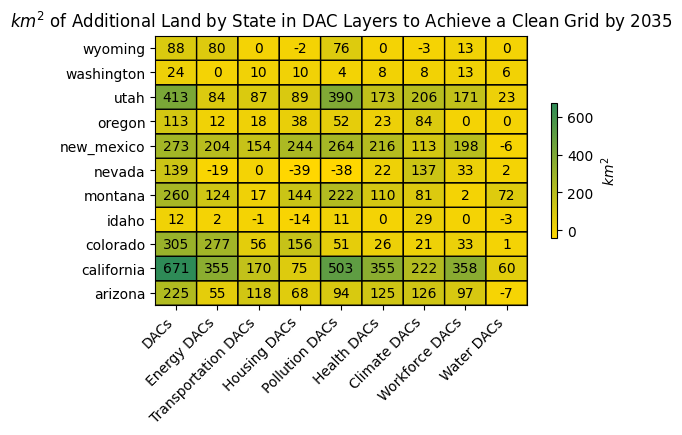

In [43]:
state_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state')

plot_heatmap(plot_df=state_intersections, 
             title=f'$km^2$ of Additional Land by State in {analysis_type} to Achieve a Clean Grid by 2035',figsize=(6, 3.5),
             output_file_name='layer_heatmaps/heatmap_diff_state_dac.png')

##### Calculate Total Intersections by State & Technology

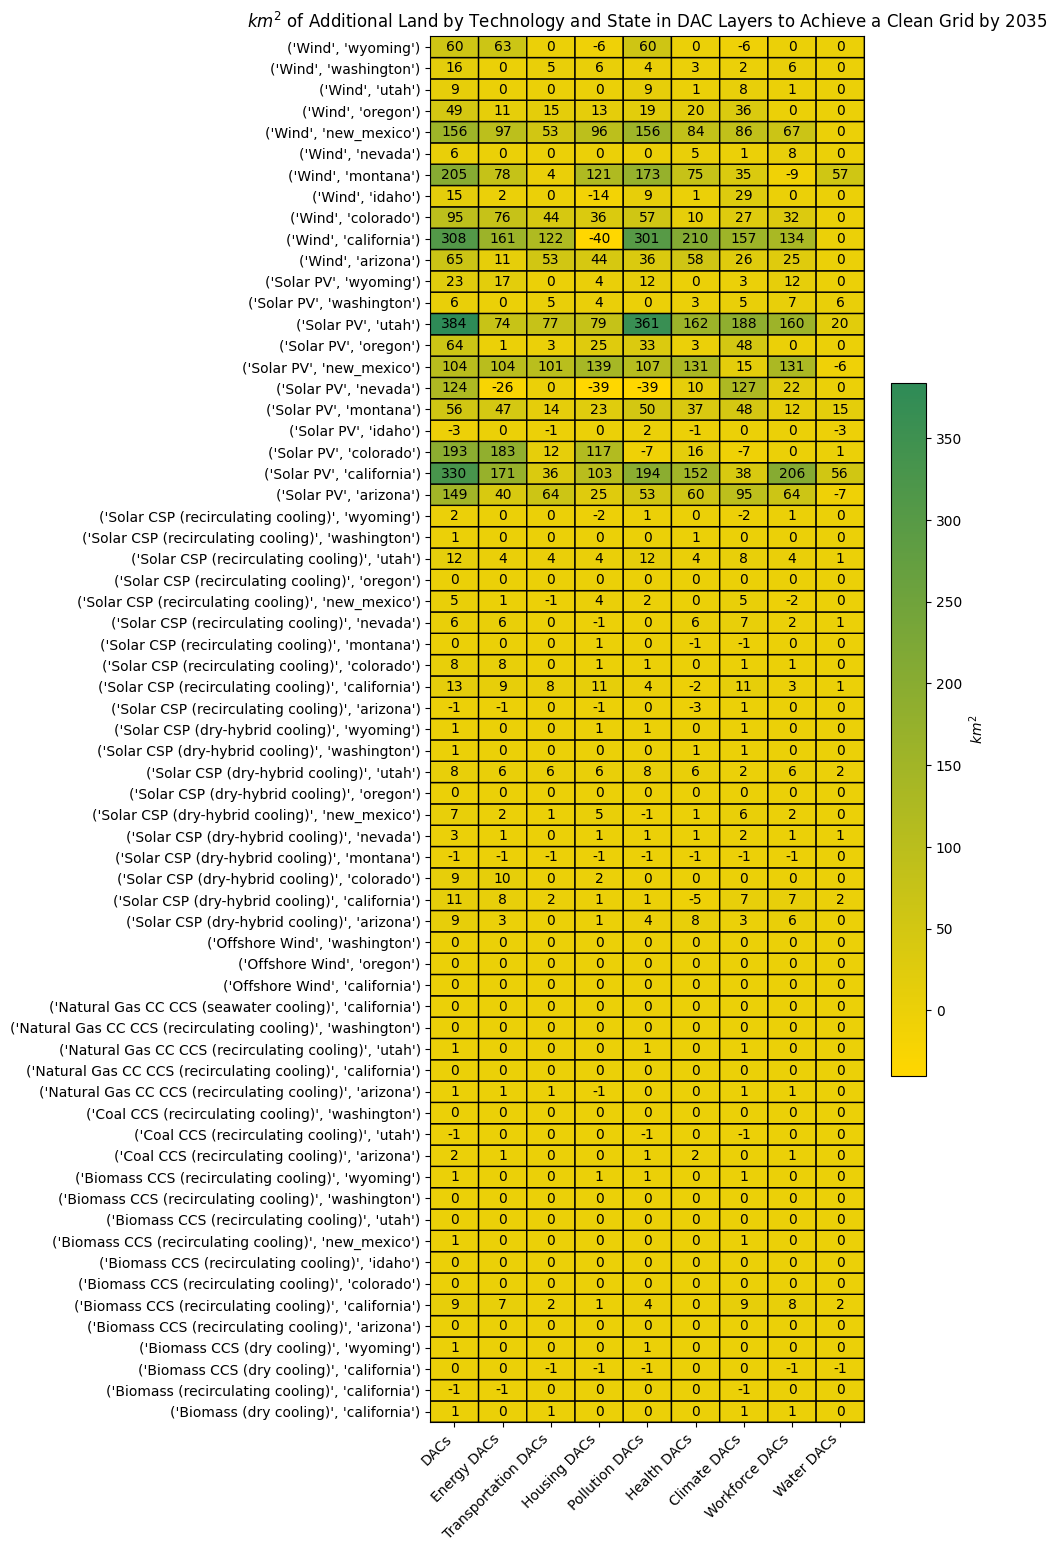

In [44]:
state_tech_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state_tech')

plot_heatmap(plot_df=state_tech_intersections, 
             title=f'$km^2$ of Additional Land by Technology and State in {analysis_type} to Achieve a Clean Grid by 2035', figsize=(7, 18),
             output_file_name='layer_heatmaps/heatmap_diff_tech_state_dac.png')


## Important Farmland


In [45]:
analysis_type = 'Important Farmland Layers'
layer_dict = farm_dict

In [46]:
analysis_df = diff_farm_df.copy()

##### Calculate Total Intersections by Layer

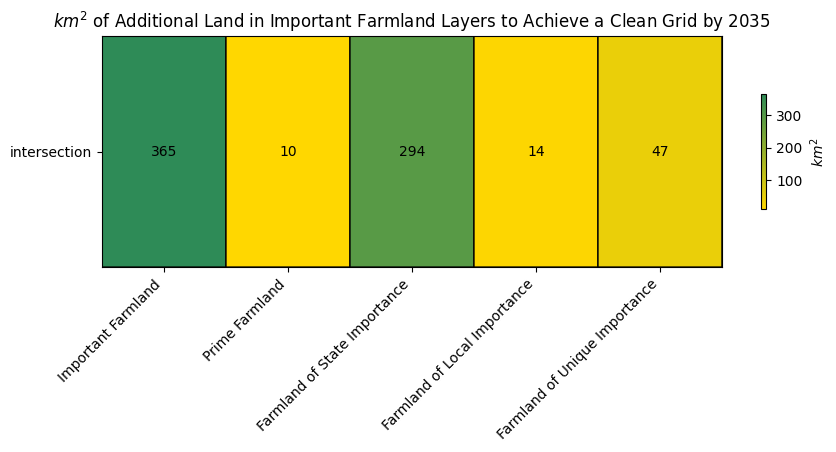

In [47]:
total_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level=None)

plot_heatmap(plot_df=total_intersections, title=f'$km^2$ of Additional Land in {analysis_type} to Achieve a Clean Grid by 2035', 
             figsize=(10, 3), output_file_name='layer_heatmaps/heatmap_diff_total_farmland.png')

##### Calculate Total Intersections by Technology

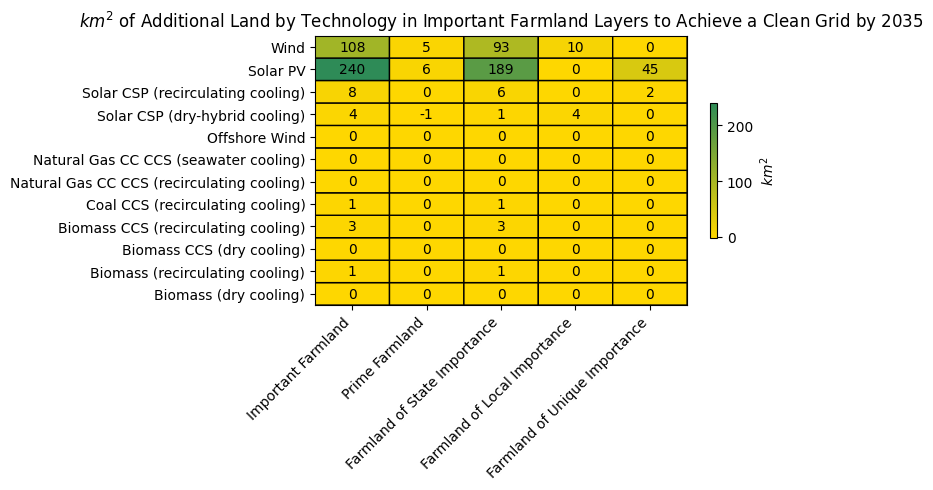

In [48]:
tech_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='tech')

plot_heatmap(plot_df=tech_intersections, 
             title=f'$km^2$ of Additional Land by Technology in {analysis_type} to Achieve a Clean Grid by 2035',figsize=(6, 3.5),
             output_file_name='layer_heatmaps/heatmap_diff_tech_farmland.png')

##### Calculate Total Intersections by State

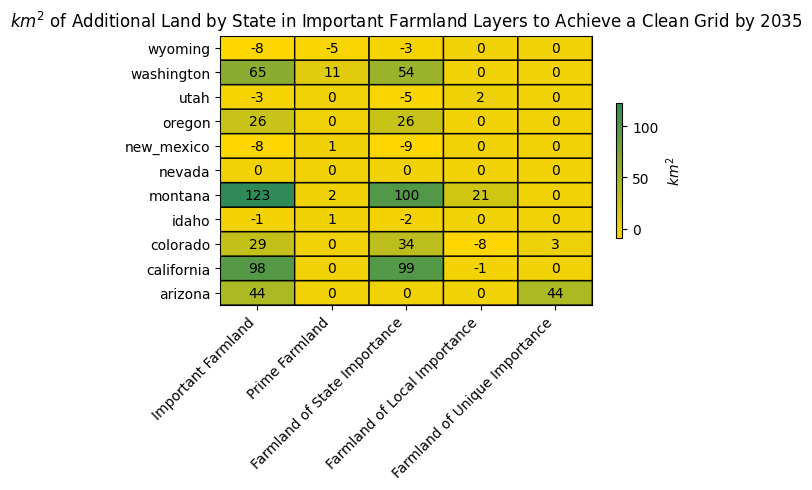

In [49]:
state_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state')

plot_heatmap(plot_df=state_intersections, 
             title=f'$km^2$ of Additional Land by State in {analysis_type} to Achieve a Clean Grid by 2035',figsize=(6, 3.5),
             output_file_name='layer_heatmaps/heatmap_diff_state_farmland.png')

##### Calculate Total Intersections by State & Technology

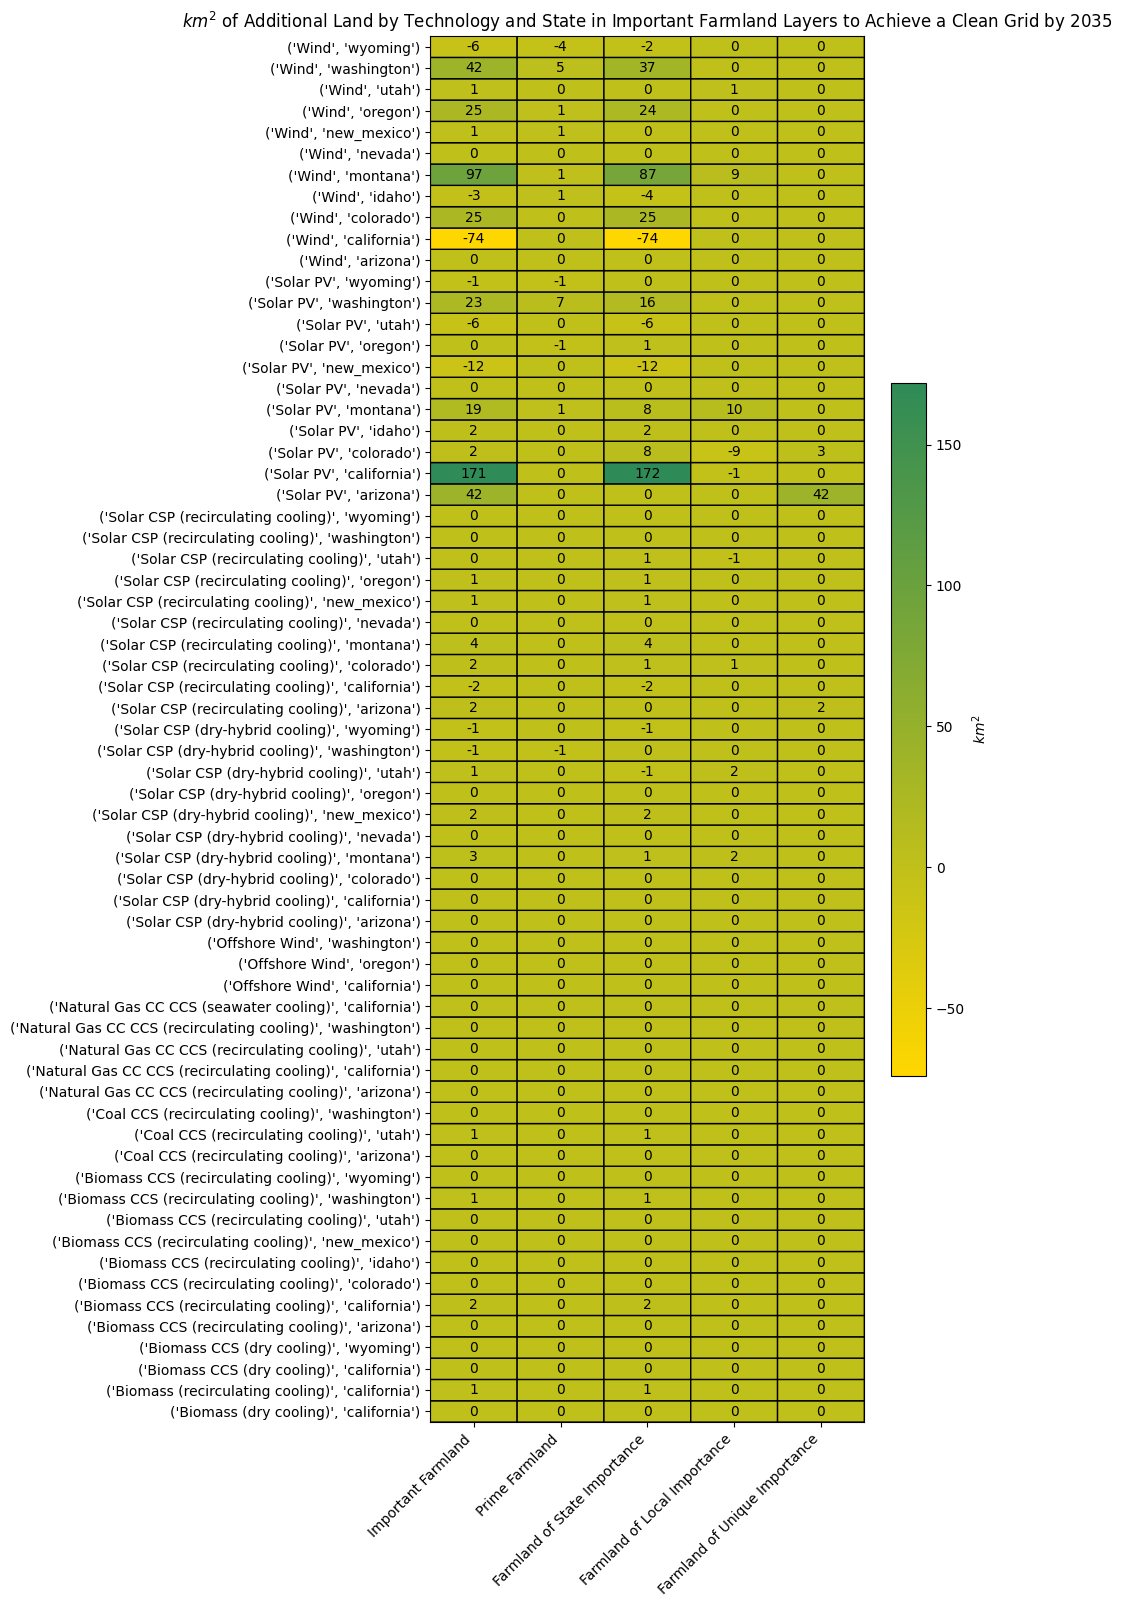

In [50]:
state_tech_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state_tech')

plot_heatmap(plot_df=state_tech_intersections, 
             title=f'$km^2$ of Additional Land by Technology and State in {analysis_type} to Achieve a Clean Grid by 2035', figsize=(7, 18),
             output_file_name='layer_heatmaps/heatmap_diff_tech_state_farmland.png')


## Natural Area Proximity

In [51]:
analysis_type = 'Natural Area Layers'
layer_dict = env_dict

In [52]:
analysis_df = diff_env_df.copy()

##### Calculate Total Intersections by Layer

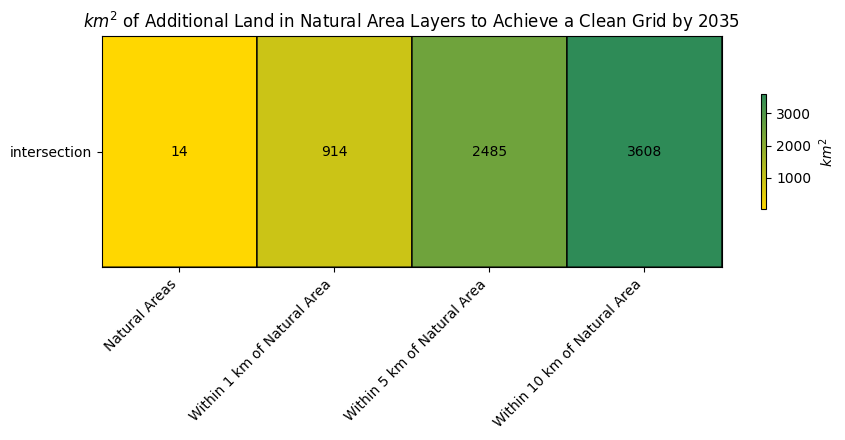

In [53]:
total_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level=None)

plot_heatmap(plot_df=total_intersections, title=f'$km^2$ of Additional Land in {analysis_type} to Achieve a Clean Grid by 2035', 
             figsize=(10, 3), output_file_name='layer_heatmaps/heatmap_diff_total_env_proximity.png')

##### Calculate Total Intersections by Technology

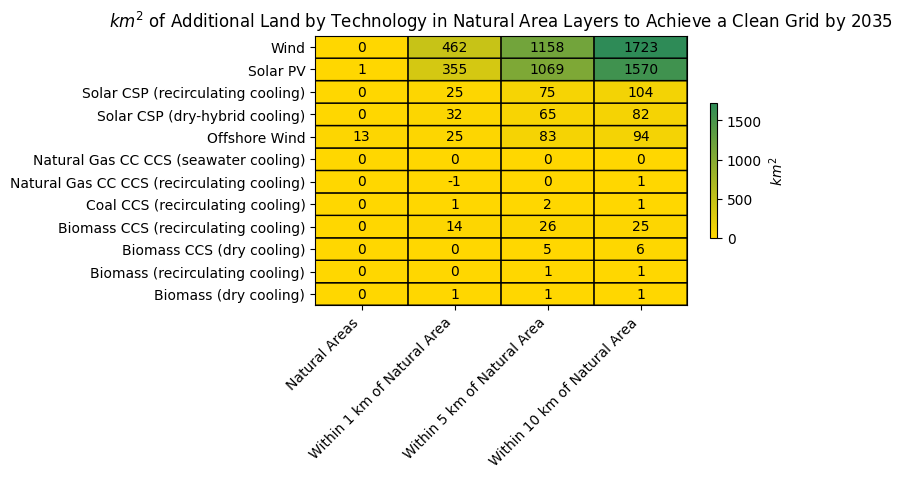

In [54]:
tech_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='tech')

plot_heatmap(plot_df=tech_intersections, 
             title=f'$km^2$ of Additional Land by Technology in {analysis_type} to Achieve a Clean Grid by 2035',figsize=(6, 3.5),
             output_file_name='layer_heatmaps/heatmap_diff_tech_env_proximity.png')

##### Calculate Total Intersections by State

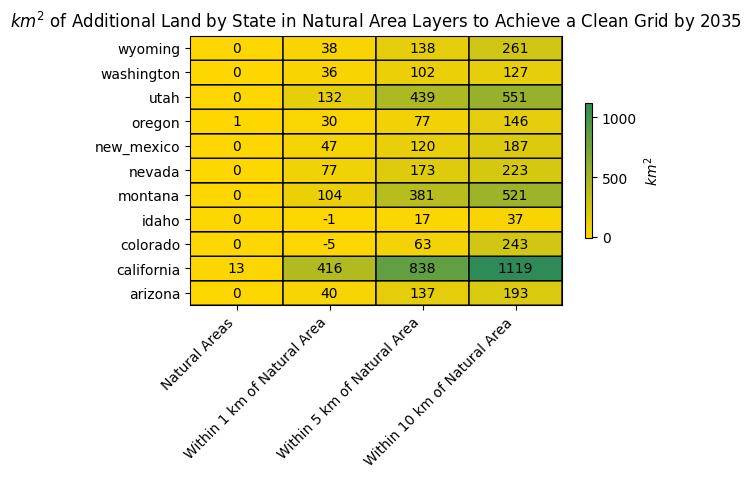

In [55]:
state_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state')

plot_heatmap(plot_df=state_intersections, 
             title=f'$km^2$ of Additional Land by State in {analysis_type} to Achieve a Clean Grid by 2035',figsize=(6, 3.5),
             output_file_name='layer_heatmaps/heatmap_diff_state_env_proximity.png')

##### Calculate Total Intersections by State & Technology

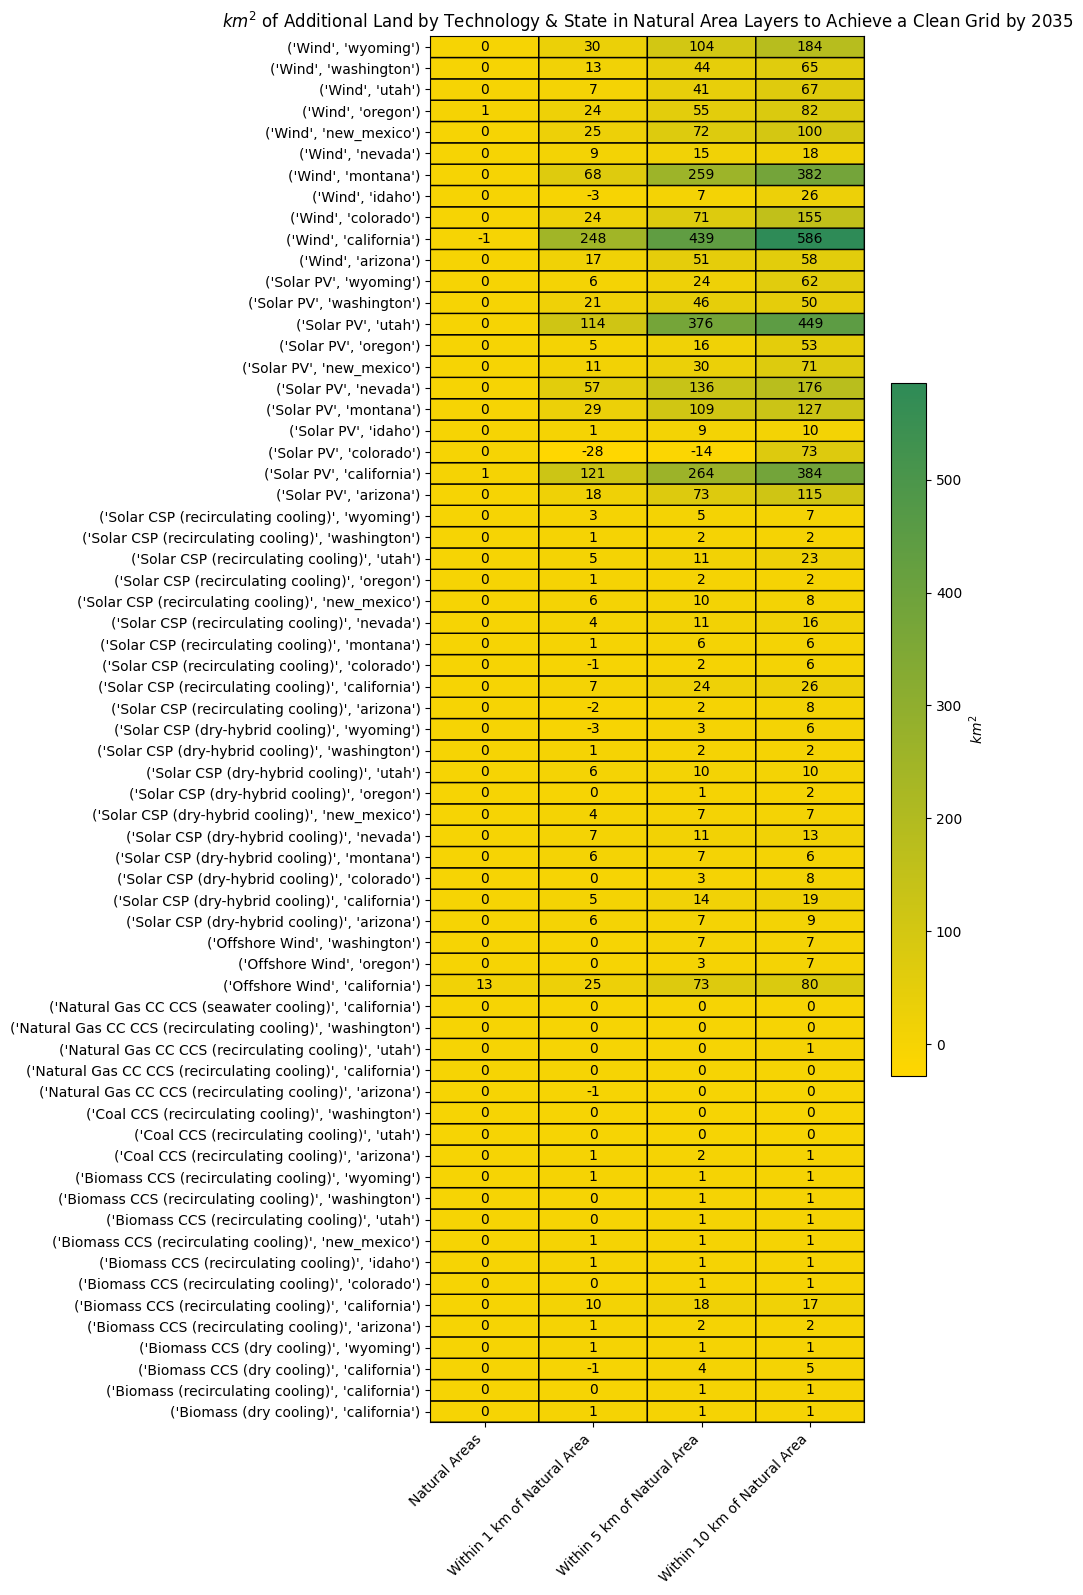

In [56]:
state_tech_intersections = calculate_total_intersections_by_layer(analysis_df=analysis_df, layer_dict=layer_dict, level='state_tech')

plot_heatmap(plot_df=state_tech_intersections, 
             title=f'$km^2$ of Additional Land by Technology & State in {analysis_type} to Achieve a Clean Grid by 2035', figsize=(7, 18),
             output_file_name='layer_heatmaps/heatmap_diff_tech_state_env_proximity.png')
